# Sentiment Analysis on Yelp Open Dataset for Review Classification

Il notebook seguente andrà ad illustrare l'intero processo per l'implementazione di un modello di Sentiment Analysis in grado di classificare le reviews in positive o negative tramite l'uso di modelli di Deep Learning.

### Import Libraries

In [98]:
# librerie di default
import pandas as pd
import numpy as np

# librerie per il data analysis
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

# librerie per il text manipulation
import gensim
from gensim.parsing.preprocessing import remove_stopwords
import nltk as nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from collections import Counter, defaultdict
from datetime import datetime
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# librerie per il data modelling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kode/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/kode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Data Loading

Date le grandezze eccessive del dataset di input, si è deciso di caricare i dati al suo interno tramite la divisione in blocchi di grandezza pari a chunksize. Inoltre, tramite la documentazione fornita da Yelp, siamo stati in grado di tener conto del numero di byte da caricare grazie alla nota tipizzazione delle informazioni.

In [138]:
# definiamo i tipi degli attributi JSON per l'attributo dtype di read_json
rtypes = {  "review_id": str,
            "user_id":str,
            "business_id":str,
            "stars": np.float16, 
            "useful": np.int32, 
            "funny": np.int32,
            "cool": np.int32,
            "text" : str,
           }

# file path del dataset json
path = './data/yelp_academic_dataset_review.json'

# grandezza dei chunk
chunkSize = 10000

In [139]:
%%time
# creazione del JsonReader
review = pd.read_json(path, lines=True,
                      orient="records",
                      dtype=rtypes,
                      chunksize=chunkSize)
chunkList = []

# utilizzo della segmentazione in chunk per creare dal JsonReader il dataframe
for chunkReview in review:
    # rimozione degli attributi id
    chunkReview = chunkReview.drop(['review_id', 'user_id','business_id'], axis=1)
    chunkList.append(chunkReview)
    
# concatenazione degli elementi nella chunkList per righe
df = pd.concat(chunkList, ignore_index=True, axis=0)

CPU times: user 1min 42s, sys: 32.2 s, total: 2min 15s
Wall time: 2min 29s


In [140]:
# visualizzazione degli elementi in testa
df.head()

,stars,useful,funny,cool,text,date
0,4.0,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02
1,4.0,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25
2,5.0,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06
3,2.0,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15
4,4.0,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01


## 2. Data Analysis

Durante la fase di Data Analysis, abbiamo concentrato il nostro interesse interesse sul bilanciamento delle valutazioni relative alla colonna stars, possibili correlazioni tra le colonne numeriche secondarie (cool, funny, useful) e analisi sulle frequenze di parole e lunghezze dei testi per la colonna texts.

In [141]:
# informazioni sulle colonne del dataframe e su quante entries o righe si hanno
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8635403 entries, 0 to 8635402
Data columns (total 6 columns):
 #   Column  Dtype         
---  ------  -----         
 0   stars   float16       
 1   useful  int32         
 2   funny   int32         
 3   cool    int32         
 4   text    object        
 5   date    datetime64[ns]
dtypes: datetime64[ns](1), float16(1), int32(3), object(1)
memory usage: 247.1+ MB


### 2.1 Stars Analysis

Text(0.5, 1.0, "Distribuzione dei valori per l'attributo stars")

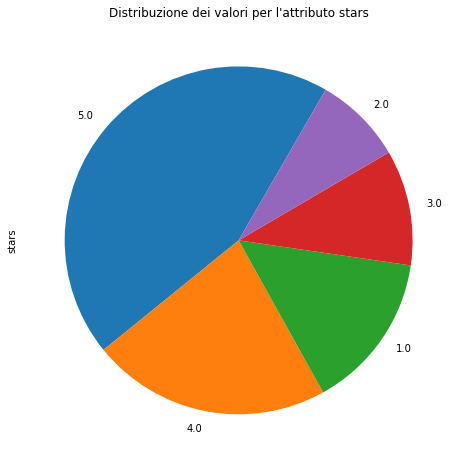

In [142]:
# definire la grandezza della figura
plt.figure(figsize=(8,8))

# contare i vari valori di stars e visualizzarli su un diagramma a torta
df['stars'].value_counts().plot.pie(startangle=60)

# definire il titolo del plot
plt.title('Distribuzione dei valori per l\'attributo stars')

Le quantità di recensioni, classificate in base al numero di stelle assegnate, è sbilanciata. Si ha un maggior numero per le recensioni con 5 e 4 stelle rispetto a quelle con 1, 2 o 3 stelle.

Text(0.5, 1.0, 'Distribuzione dei valori positivi e negativi')

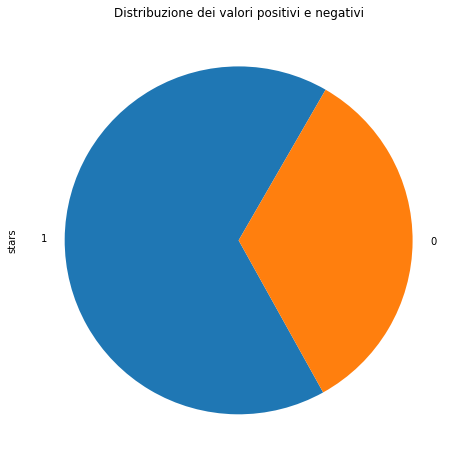

In [143]:
# distribuzione dei valori in reviews positive e negative
binstars = pd.DataFrame()
binstars['stars'] = [0 if star <= 3.0 else 1 for star in df['stars']]
# definire la grandezza della figura
plt.figure(figsize=(8,8))


# contare i vari valori di stars e visualizzarli su un diagramma a torta
binstars['stars'].value_counts().plot.pie(startangle=60)

# definire il titolo del plot
plt.title('Distribuzione dei valori positivi e negativi')

### 2.2 Cool, Fun and Useful Analysis

In [144]:
# Aggiunta di una feature per l'analisi della lunghezza dei testi
df['textLength']  = df['text'].str.len()

<AxesSubplot:>

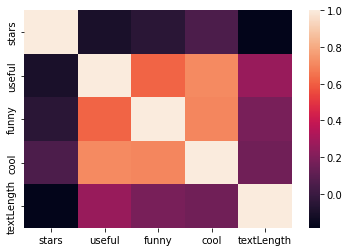

In [145]:
# definire le correlazioni
corr = df.corr()

# generazione dell'heatmap
sns.heatmap(corr)

Non sono presenti particolari correlazioni forti tra i funny, useful e cool con i valori dati a stars o text.

### 2.3 Text Analysis

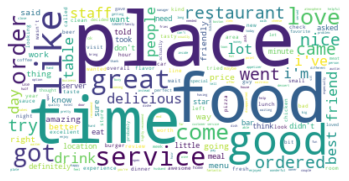

CPU times: user 21.5 s, sys: 961 ms, total: 22.5 s
Wall time: 22.6 s


In [146]:
%%time

# definisce un sottoinsieme delle righe del dataset
subset = df[:100000]
# concatenazione dei testi di ogni riga in una singola stringa
inputText = ' '.join(subset['text']).lower()

# creazione di un wordcloud andando ad ignorare le stopwords
wordCloud = WordCloud(background_color='white', stopwords=gensim.parsing.preprocessing.STOPWORDS).generate(inputText)
# setting della visualizzazione utilizzando una interpolazione bilineare
plt.imshow(wordCloud, interpolation='bilinear')

# rimozione degli assi
plt.axis('off')
# visualizzazione del wordcloud rappresentante le parole più usate nel testo di una recensione
plt.show()

Poichè la maggior parte delle recensioni fanno riferimento ad attività che forniscono servizi (ristorazione o di altro genere), l'utilizzo di parole che possano descrivere il luogo o i vari aspetti dell'attività sono quelle riscontrate con più frequenza.

In [147]:
# calcolo della frequenza dei termini più utilizzati
wordTokens = word_tokenize(inputText)
tokens = list()
for word in wordTokens:
    if word.isalpha() and word not in gensim.parsing.preprocessing.STOPWORDS:
        tokens.append(word)
tokenDist = FreqDist(tokens)
# per questioni di visualizzazione, andiamo a prendere solamente i primi 20 termini utilizzati
dist = pd.DataFrame(tokenDist.most_common(20),columns=['term', 'freq'])

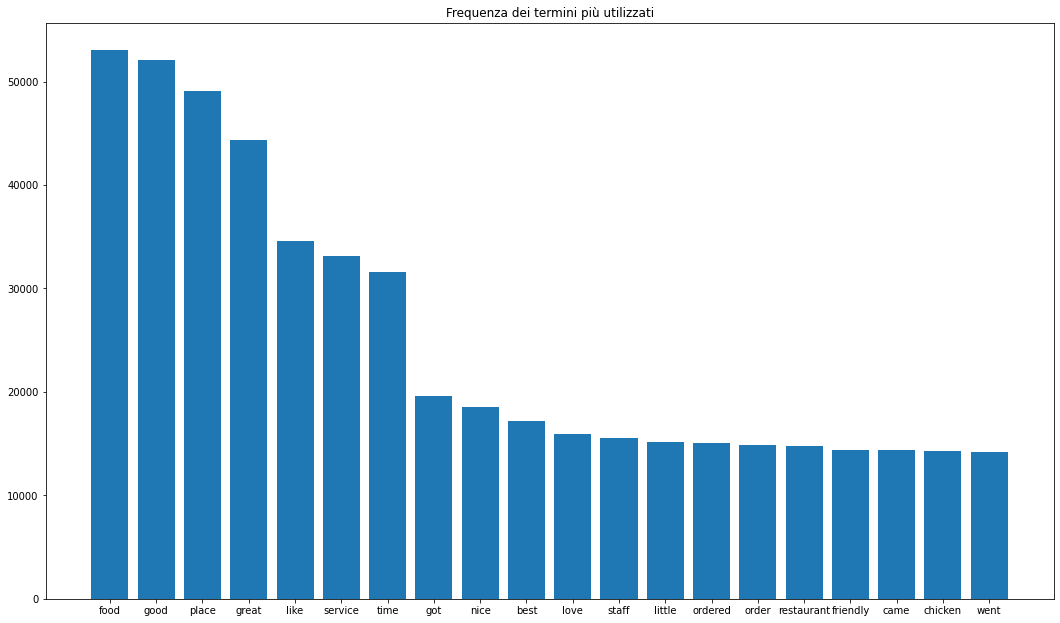

In [148]:
# rappresentazione grafica dei risultati
fig = plt.figure(figsize=(14,8))
ax = fig.add_axes([0,0,1,1])
x = dist['term']
y = dist['freq']
ax.bar(x,y)
plt.title('Frequenza dei termini più utilizzati')
plt.show()

Tramite il grafico delle frequenze, possiamo notare come la maggior parte delle recensioni sono di natura culinaria, ossia una descrizione del cibo che si è ordinato. Da osservare che, dato lo sbilanciamento delle valutazioni a favore delle recensioni con valutazioni maggiore, parole usate per giudizi positivi risultano con più frequenza.

In [149]:
df.head()

,stars,useful,funny,cool,text,date,textLength
0,4.0,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02,1856
1,4.0,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25,701
2,5.0,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06,578
3,2.0,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15,390
4,4.0,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01,181


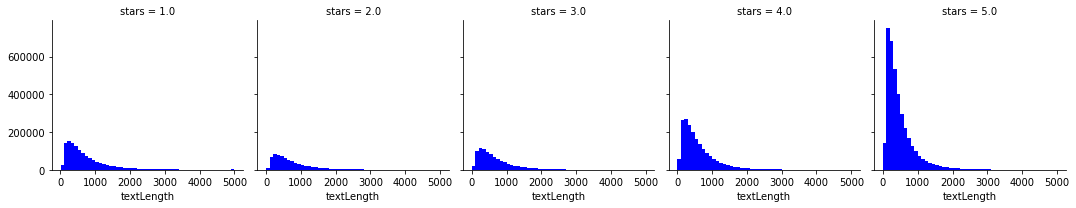

In [150]:
# Differenziazione della lunghezza dei testi in relazione alla valutazione data a stars
graph = sns.FacetGrid(data=df,col='stars')
graph.map(plt.hist,'textLength',bins=50,color='blue')

## 3. Data Pre-processing

La procedura di data pre-processing sarà utilizzata per la divisione delle valutazioni secondo una classificazione binaria (stars <= 3 per review negativa, positiva altrimenti). Durante tale fase, ci siamo concentrati principalmente sulla manipolazione del testo, nello specifico abbiamo ridotto la diversificazione delle parole andando a rimuovere segni di punteggiatura, stopwords e forme alternative. Infine, abbiamo utilizzato un tokenizer in grado di poter effettuare una conversione in valori numerici (stemmizzazione) dato che, trattandosi di deep learning, il calcolo relativo alle funzioni di attivazione e del processing interno di una rete si basa esclusivamente su valori di natura numerica. 

### 3.1 Rimozione colonne inutilizzate e valori nulli

In [ ]:
# cancellazione delle caratteristiche cool, funny, useful e textLength poichè non hanno correlazioni con stars.
df = df.drop(['cool', 'funny', 'useful', 'textLength'], axis=1)

In [ ]:
df.head()

In [ ]:
# rimozione di possibili testi vuoti
df['text'].dropna(inplace=True)

### 3.2 Riduzione dei testi in lowercase

In [ ]:
# ridurre la forma delle parole in minuscolo
df['text'] = [review_text.lower() for review_text in df['text']]

In [ ]:
df['text'].head()

### 3.3 Polarizzazione dei labels (stars) e bilanciamento del dataset

In [ ]:
# polarizzazione delle valutazioni a stars in due categorie: 1 = positiva, 0 = negativa

# isoliamo la colonna di testo del dataframe in texts
texts =  df['text']

# andiamo ad impostare negative tutte le recensioni con 3 o meno stelle e positive quelle con 4 e 5 stelle.
stars = [0 if star <= 3.0 else 1 for star in df['stars']]

balancedTexts = [] # rappresenta la collezione di testi presi in considerazione dal dataframe di input
balancedLabels = [] # rappresenta il nuovo valore polarizzato assegnato all'entry (0,1)

# andiamo a bilanciare il dataset andando a dividere recensioni positive e negative con limite di 1.000.000 per categoria
limit = 100000  

# posizione 0 per conteggio di recensioni negative, posizione 1 per quelle positive
negPosCounts = [0, 0] 

for i in range(0,len(texts)):
    polarity = stars[i]
    if negPosCounts[polarity] < limit: # se non si è raggiunto il limite per la categoria di polarizzazione
        balancedTexts.append(texts[i])
        balancedLabels.append(stars[i])
        negPosCounts[polarity] += 1

In [ ]:
df_balanced = pd.DataFrame()
df_balanced['text'] = balancedTexts
df_balanced['labels'] = balancedLabels
df_balanced.head()

In [ ]:
# verifica del conteggio
counter = Counter(df_balanced['labels'])
print(f'Ci sono {counter[1]} recensioni positive e {counter[0]} recensioni negative')

### 3.3 Lemmatizzazione

In [ ]:
%%time
# creazione del lemmatizer
lemmatizer = WordNetLemmatizer()

# funzione per l'aggiunta del tag semantico che evidenzia il tipo di parola da dover selezionare
def word_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None


# elaborazione sui testi del dataset
texts = df_balanced['text']
df_texts = []
for text in texts:
    # tokenizzazione del text per l'aggiunta dei tag
    word_tagged = nltk.pos_tag(nltk.word_tokenize(text))
    # mapping parole:tag del testo analizzato
    map_word_tag = list(map(lambda x: (x[0], word_tagger(x[1])), word_tagged))
    # costruzione del testo lemmatizzato
    lemmatized_text = []
    for word, tag in map_word_tag:
        if tag is None:
            # elemento non tokenizzabile
            lemmatized_text.append(word)
        else:
            # lemmmatizzazione della parola in relazione al 
            # tipo di elemento
            lemmatized_text.append(lemmatizer.lemmatize(word, tag))
    # aggiunta della parola post-lemmatizzazione al testo selezionato
    lemmatized_text = " ".join(lemmatized_text)
    # aggiunta del testo nella collezione dei testi lemmatizzati
    df_texts.append(lemmatized_text)

print(texts[0] + "\n\n")
print(df_texts[0])

In [ ]:
df_balanced['text'] = df_texts

### 3.4 Rimozione delle stop words e di caratteri non alfanumerici

In [ ]:
# Stop words da rimuovere
print(gensim.parsing.preprocessing.STOPWORDS)

In [ ]:
# Rimozione delle stop words
df_texts = []
for text in df_balanced['text']:
    df_texts.append(remove_stopwords(text))

df_balanced['text'] = df_texts

# Rimozione dei caratteri non alfanumerici
df_texts = []
for text in df_balanced['text']:
    df_texts.append(''.join(ch for ch in text if ch.isalnum() or ch == ' '))

df_balanced['text'] = df_texts

In [ ]:
print(df_balanced['text'])

### 3.5 Text Tokenization

In [ ]:
%%time
# tokenizzazione del testo andando a dividere le stringhe in una lista di lemmi
df_balanced['text'] = [word_tokenize(text) for text in df_balanced['text']]

### 3.6 Preparazione Dati Vettoriali per la Fase di Modelling

In [ ]:
%%time
# definizione di un tokenizer di 10.000 parole prese dal dataframe
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df_balanced['text'])
# trasformazione della sequenza di lemmi in sequenze di interi in modo da valutare più velocemente le parole
sequences = tokenizer.texts_to_sequences(df_balanced['text'])
# Sequenze di massimo 200 unità. Se vi sono testi con sequenze più lunghe esse vengono troncate, altrimenti si avrà 
# un riempimenti di 0 per testi undersized.
text_sequence = pad_sequences(sequences, maxlen=200)
labels = np.array(df_balanced['labels'])

In [ ]:
# check parziale degli indici delle parole 
word_index = tokenizer.word_index
# prendiamo le prime 50 parole indicizzate
check = {key: value for key, value in word_index.items() if value <= 50}
print(check)

## 4. Modelling

In questa fase è possibile trovare modelli alternativi utilizzati oggigiorno nel campo NLP. Nello specifico, si propone una triplice alternativa che vede l'utilizzo di un modello basato su LSTM, un modello di convulational neural network e, infine, un modello di LSTM bidirezionale. Possiamo affermare che tutti i modelli hanno raggiunto un livello di precisione accettabile; ciò non toglie che vi possano essere vari miglioramenti che possano incrementarne le prestazioni.

In [99]:
# Checking sulle compile flags di tensorflow
print(tf.sysconfig.get_compile_flags())
print(tf.__version__)

['-I/usr/local/lib/python3.9/site-packages/tensorflow/include', '-D_GLIBCXX_USE_CXX11_ABI=0', '-DEIGEN_MAX_ALIGN_BYTES=64']
2.6.0


In [100]:
# train and test splitting
x_train, x_test, y_train, y_test = train_test_split(text_sequence , labels ,random_state=520, test_size=0.33, shuffle=True)

### 4.1 Modello basato su LSTM

In [109]:
# creazione di un modello sequenziale vuoto in cui aggiungere i vari layers
model_lstm = keras.Sequential()

# aggiunta dei layers
model_lstm.add(layers.Embedding(10000, 128, 
                                input_length=200))
model_lstm.add(layers.LSTM(128, 
                           dropout=0.2, 
                           recurrent_dropout=0.2));
model_lstm.add(layers.Dense(1, activation='sigmoid'));

model_lstm.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 128)          1280000   
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________


In [110]:
results_lstm = model_lstm.fit(x_train, y_train, validation_split=0.4, epochs=3, batch_size=32)

Epoch 1/3
2513/2513 [==============================] - 680s 270ms/step - loss: 0.3524 - accuracy: 0.8483 - val_loss: 0.3228 - val_accuracy: 0.8587
Epoch 2/3
2513/2513 [==============================] - 663s 264ms/step - loss: 0.2705 - accuracy: 0.8875 - val_loss: 0.3164 - val_accuracy: 0.8670
Epoch 3/3
2513/2513 [==============================] - 675s 269ms/step - loss: 0.2299 - accuracy: 0.9038 - val_loss: 0.3254 - val_accuracy: 0.8641


In [111]:
model_lstm.evaluate(x_test, y_test)

2063/2063 [==============================] - 61s 29ms/step - loss: 0.3216 - accuracy: 0.8660


[0.32162413001060486, 0.8660151362419128]

modelLSTM.evaluate(xTest, yTest)

### 4.1.1 Aggiunta di layers per la regolarizzazione

In [131]:
# creazione di un modello sequenziale vuoto in cui aggiungere i vari layers
model_lstm = keras.Sequential()

# aggiunta dei layers
model_lstm.add(layers.Embedding(10000, 128, input_length=200))
model_lstm.add(layers.Dropout(0.25))
model_lstm.add(layers.Conv1D(128, 
                             3, 
                             padding='valid', 
                             activation='relu'))
model_lstm.add(layers.MaxPooling1D(pool_size=3))
model_lstm.add(layers.LSTM(128, 
                           dropout=0.2, 
                           recurrent_dropout=0.2));
model_lstm.add(layers.Dense(1, activation='sigmoid'));

model_lstm.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

model_lstm.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 200, 128)          1280000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 200, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 198, 128)          49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 66, 128)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 1,460,993
Trainable params: 1,460,993
Non-trainable params: 0
____________________________________________

In [132]:
results_lstm = model_lstm.fit(x_train, y_train, validation_split=0.4, epochs=3, batch_size=32)

Epoch 1/3
1257/1257 [==============================] - 192s 151ms/step - loss: 0.3405 - accuracy: 0.8496 - val_loss: 0.3000 - val_accuracy: 0.8698
Epoch 2/3
1257/1257 [==============================] - 203s 162ms/step - loss: 0.2620 - accuracy: 0.8899 - val_loss: 0.2999 - val_accuracy: 0.8700
Epoch 3/3
1257/1257 [==============================] - 218s 173ms/step - loss: 0.2190 - accuracy: 0.9091 - val_loss: 0.3266 - val_accuracy: 0.8660


In [133]:
model_lstm.evaluate(x_test, y_test)

2063/2063 [==============================] - 35s 17ms/step - loss: 0.3234 - accuracy: 0.8666


[0.32339417934417725, 0.8665757775306702]

### 4.2 Modello basato su una Convulational Neural Network

In [112]:
model_cnn = keras.Sequential()
model_cnn.add(layers.Embedding(10000, 128, input_length=200)) #layer iniziali 
model_cnn.add(layers.Dropout(0.25)) # layer di dropout esterno in seguito ad Embedding
model_cnn.add(layers.Conv1D(250,
                        3,
                        padding='valid',
                        activation='relu'))
model_cnn.add(layers.MaxPooling1D(pool_size=2))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(250, activation='relu'))
model_cnn.add(layers.Dropout(0.25))
model_cnn.add(layers.Dense(1, activation='sigmoid'))


model_cnn.compile(
    loss='binary_crossentropy', 
    optimizer='rmsprop', 
    metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 128)          1280000   
_________________________________________________________________
dropout (Dropout)            (None, 200, 128)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 198, 250)          96250     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 99, 250)           0         
_________________________________________________________________
flatten (Flatten)            (None, 24750)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 250)               6187750   
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)              

In [113]:
results_cnn = model_cnn.fit(x_train, y_train, validation_split=0.4, epochs=3, batch_size=32)

Epoch 1/3
2513/2513 [==============================] - 212s 84ms/step - loss: 0.3435 - accuracy: 0.8529 - val_loss: 0.3127 - val_accuracy: 0.8705
Epoch 2/3
2513/2513 [==============================] - 211s 84ms/step - loss: 0.2907 - accuracy: 0.8810 - val_loss: 0.3138 - val_accuracy: 0.8735
Epoch 3/3
2513/2513 [==============================] - 211s 84ms/step - loss: 0.2722 - accuracy: 0.8888 - val_loss: 0.3131 - val_accuracy: 0.8655


In [114]:
model_cnn.evaluate(x_test, y_test)

2063/2063 [==============================] - 19s 9ms/step - loss: 0.3115 - accuracy: 0.8655


[0.31152552366256714, 0.8655303120613098]

### 4.3 Modello basato su LSTM bidirezionale

In [115]:
model_bid = keras.Sequential()
model_bid.add(layers.Embedding(10000, 128, input_length=200))
model_bid.add(layers.Bidirectional(layers.LSTM(128)))
model_bid.add(layers.Dense(64, activation='relu'))
model_bid.add(layers.Dropout(0.25))
model_bid.add(layers.Dense(1, activation='sigmoid'))
model_bid.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

model_bid.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 200, 128)          1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense_11 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 1,559,681
Trainable params: 1,559,681
Non-trainable params: 0
_________________________________________________________________


In [116]:
results_bid = model_bid.fit(x_train, y_train, validation_split=0.4, epochs=3, batch_size=32)

Epoch 1/3
2513/2513 [==============================] - 525s 208ms/step - loss: 0.3503 - accuracy: 0.8488 - val_loss: 0.3315 - val_accuracy: 0.8568
Epoch 2/3
2513/2513 [==============================] - 530s 211ms/step - loss: 0.2718 - accuracy: 0.8866 - val_loss: 0.3118 - val_accuracy: 0.8648
Epoch 3/3
2513/2513 [==============================] - 528s 210ms/step - loss: 0.2263 - accuracy: 0.9069 - val_loss: 0.3355 - val_accuracy: 0.8607


In [117]:
model_bid.evaluate(x_test,y_test)

2063/2063 [==============================] - 113s 54ms/step - loss: 0.3307 - accuracy: 0.8626


[0.3306758403778076, 0.8626060485839844]

## 5. Save Models

Data l'eccessiva tempo speso per l'addestramento delle reti neurali proposte, abbiamo deciso di salvare tramite la libreria pickle le componenti e i modelli addestrati in modo da poterli rendere disponibili per l'analisi delle prestazioni e l'utilizzo.

In [118]:
import pickle

# salviamo il tokenizer e i modelli su file
with open("dump/keras_tokenizer.pickle", "wb") as f:
    pickle.dump(tokenizer, f)
    
model_lstm.save("dump/model/yelp_model_lstm.hdf5")
model_cnn.save("dump/model/yelp_model_cnn.hdf5")
model_bid.save("dump/model/yelp_bidirectional.hdf5")


In [119]:
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import pickle

# carichiamo il tokenizer e il modello da file
with open("dump/keras_tokenizer.pickle", "rb") as f:
    tokenizer = pickle.load(f)

# TODO: load other models
model_lstm = load_model("dump/model/yelp_model_lstm.hdf5")
model_cnn = load_model("dump/model/yelp_model_cnn.hdf5")
model_bid = load_model("dump/model/yelp_bidirectional.hdf5")

# definiamo gli esempi su cui testare il modello
examples_reviews = ["slow orders but good food", "Delicious foods! Awesome!", "Bad food, bad people... horrible!"]

# usiamo il tokenizer per creare sequenze di interi da dare al modello
sequences = tokenizer.texts_to_sequences(examples_reviews)
data_examples = pad_sequences(sequences, maxlen=200)

# effettuare le predizioni e stampare i risultati
predictions_lstm = model_lstm.predict(data_examples)
predictions_cnn = model_cnn.predict(data_examples)
predictions_bid = model_bid.predict(data_examples)

print(f"Risultati model_lstm:\n {predictions_lstm}\n\n"+
    f"Risultati model_lstm_v2:\n {predictions_cnn}\n\n" + 
      f"Risultati model_bid:\n {predictions_bid}")

Risultati model_lstm:
 [[0.04498807]
 [0.9486532 ]
 [0.00687218]]

Risultati model_lstm_v2:
 [[0.21444261]
 [0.9326371 ]
 [0.00232181]]

Risultati model_bid:
 [[0.02945179]
 [0.98629963]
 [0.00164512]]


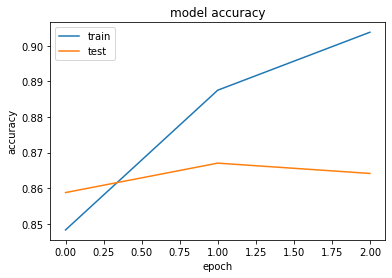

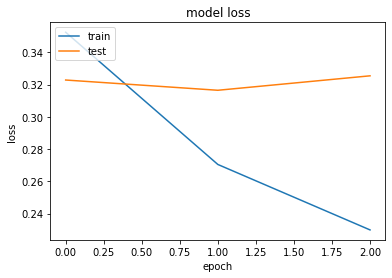

In [120]:
# grafico della variazione della precisione tra il train e il validation set tra le varie 
# epoch di apprendimento per il modello LSTM.
plt.plot(results_lstm.history['accuracy'])
plt.plot(results_lstm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# grafico della variazione del valore della loss function tra il train e il validation set tra le varie 
# epoch di apprendimento per il modello LSTM.
plt.plot(results_lstm.history['loss'])
plt.plot(results_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


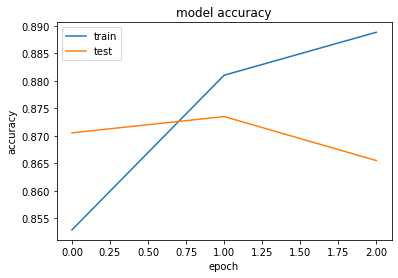

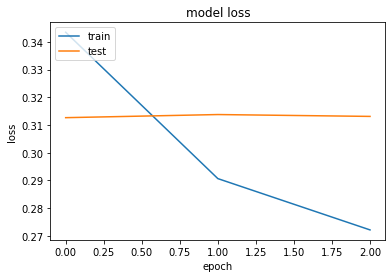

In [121]:
# grafico della variazione della precisione tra il train e il validation set tra le varie 
# epoch di apprendimento per il modello CNN,
plt.plot(results_cnn.history['accuracy'])
plt.plot(results_cnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# grafico della variazione del valore della loss function tra il train e il validation set tra le varie 
# epoch di apprendimento per il modello CNN.
plt.plot(results_cnn.history['loss'])
plt.plot(results_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

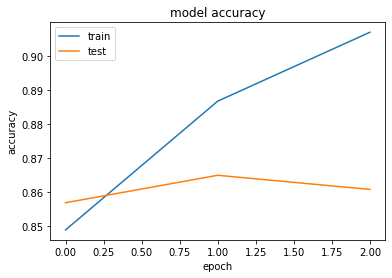

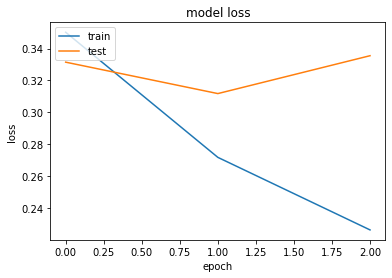

In [122]:
# grafico della variazione della precisione tra il train e il validation set tra le varie 
# epoch di apprendimento per il modello BRNN.
plt.plot(results_bid.history['accuracy'])
plt.plot(results_bid.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# grafico della variazione del valore della loss function tra il train e il validation set tra le varie 
# epoch di apprendimento per il modello BRNN.
plt.plot(results_bid.history['loss'])
plt.plot(results_bid.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

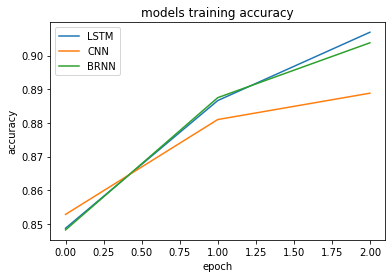

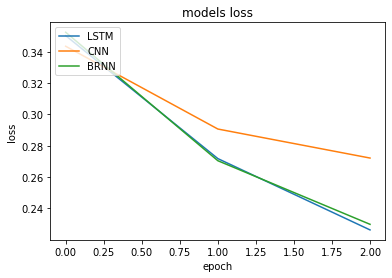

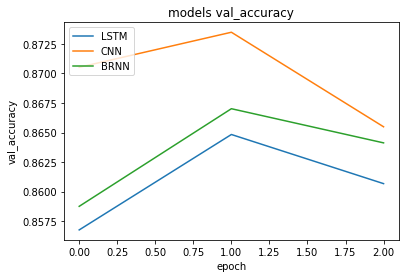

In [129]:
# grafico di paragone per i valori della training accuracy tra i modelli proposti
plt.plot(results_bid.history['accuracy'])
plt.plot(results_cnn.history['accuracy'])
plt.plot(results_lstm.history['accuracy'])
plt.title('models training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['LSTM', 'CNN', 'BRNN'], loc='upper left')
plt.show()


# grafico di paragone per i valori della loss function tra i modelli proposti
plt.plot(results_bid.history['loss'])
plt.plot(results_cnn.history['loss'])
plt.plot(results_lstm.history['loss'])
plt.title('models loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['LSTM', 'CNN', 'BRNN'], loc='upper left')
plt.show()

# grafico di paragone per i valori dell'accuracy in validazione
plt.plot(results_bid.history['val_accuracy'])
plt.plot(results_cnn.history['val_accuracy'])
plt.plot(results_lstm.history['val_accuracy'])
plt.title('models val_accuracy')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['LSTM', 'CNN', 'BRNN'], loc='upper left')
plt.show()

In [127]:
results_lstm.history

{'loss': [0.35240158438682556, 0.27045363187789917, 0.22988983988761902],
 'accuracy': [0.8482587337493896, 0.887499988079071, 0.9037811160087585],
 'val_loss': [0.3227873146533966, 0.3164404034614563, 0.3253938555717468],
 'val_accuracy': [0.8587499856948853, 0.8670149445533752, 0.8641231060028076]}